# **Data Preparation & Modeling**

## **1.** Imports

In [ ]:
import os
import tensorflow as tf
import kagglehub
import matplotlib.pyplot as plt
from tensorflow.keras.layers import (Dense, Flatten, Conv2D,
    MaxPooling2D, Dropout, GlobalAveragePooling2D, Rescaling,
    BatchNormalization)
from tensorflow.keras.layers import (RandomFlip, )

In [ ]:
print("Dispositivos detectados por TensorFlow:")
print(tf.config.list_physical_devices())
if tf.config.list_physical_devices('GPU'):
    print("✅ TensorFlow está usando la GPU")
else:
    print("⚠️ TensorFlow está usando solo la CPU")

Dispositivos detectados por TensorFlow:
[PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU'), PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
✅ TensorFlow está usando la GPU


In [3]:
path = kagglehub.dataset_download("zlatan599/garbage-dataset-classification")
print("Path to dataset files:", path)

100%|██████████| 121M/121M [00:00<00:00, 191MB/s]  

Extracting files...


Path to dataset files: /root/.cache/kagglehub/datasets/zlatan599/garbage-dataset-classification/versions/5


## **2.** Procesamiento de imágenes

In [4]:
print("Carpetas dentro: ", os.listdir(path))
data_path = os.path.join(path, "Garbage_Dataset_Classification", "images")
print("Carpetas dentro de Garbage Dataset: ", os.listdir(data_path))

Carpetas dentro:  ['Garbage_Dataset_Classification']
Carpetas dentro de Garbage Dataset:  ['paper', 'glass', 'cardboard', 'trash', 'metal', 'plastic']


In [5]:
img_size = (256, 256) # Formato original
num_classes = 6
batch_size = 32
seed = 42
epochs = 10

In [6]:
train_data = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split = 0.2,
    subset = "training",
    seed = seed,
    image_size = img_size,
    batch_size = batch_size
)

val_data = tf.keras.utils.image_dataset_from_directory(
    data_path,
    validation_split = 0.2,
    subset = "validation",
    seed = seed,
    image_size = img_size,
    batch_size = batch_size
)

Found 13901 files belonging to 6 classes.
Using 11121 files for training.
Found 13901 files belonging to 6 classes.
Using 2780 files for validation.


In [7]:
# Source - https://stackoverflow.com/a/74609848
# Posted by Sonjoy Das, modified by community. Version adapted to the project
# Retrieved 2025-11-07, License - CC BY-SA 4.0
val_batches = tf.data.experimental.cardinality(val_data)
test_data = val_data.take(val_batches // 2)
val_data = val_data.skip(val_batches // 2)


In [8]:
normalization_layer = Rescaling(1./255)
train_data = train_data.map(lambda x, y: (normalization_layer(x), y))
val_data = val_data.map(lambda x, y: (normalization_layer(x), y))
test_data = val_data.map(lambda x, y: (normalization_layer(x), y))

## **3.** Modelos

### **3.1.** Baseline

In [ ]:
model_baseline = tf.keras.Sequential([
    Conv2D(16, 3, activation='relu', input_shape = (256, 256, 3)),
    MaxPooling2D(),
    Conv2D(8, 3, activation='relu'),
    MaxPooling2D(),
    Flatten(),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
def compile_and_fit(model, epochs):
    model.compile(
        optimizer='adam',
        loss='sparse_categorical_crossentropy',
        metrics=['accuracy']
    )
    history = model.fit(
        train_data,
        epochs = epochs,
        validation_data = val_data
    )
    return history

In [ ]:
history_baseline = compile_and_fit(model_baseline, epochs)

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 41s 101ms/step - accuracy: 0.3502 - loss: 1.7700 - val_accuracy: 0.4972 - val_loss: 1.3386
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.5733 - loss: 1.1563 - val_accuracy: 0.5442 - val_loss: 1.2683
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.7285 - loss: 0.7556 - val_accuracy: 0.6425 - val_loss: 1.2504
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.8636 - loss: 0.4337 - val_accuracy: 0.6303 - val_loss: 1.4793
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 15s 42ms/step - accuracy: 0.9206 - loss: 0.2663 - val_accuracy: 0.6546 - val_loss: 1.7974
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.9602 - loss: 0.1480 - val_accuracy: 0.6489 - val_loss: 1.8186
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 36ms/step - accuracy: 0.9619 - loss: 0.1376 - val_accuracy: 0.6168 - val_loss: 2.3120
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 12s 36ms/step - accuracy: 0.9717 - loss: 0.1047 -

In [ ]:
model_baseline.save("trash_model_baseline.keras")

In [9]:
def visualizar_graficas(history):
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']
  eps = range(1, len(acc) + 1)

  plt.plot(eps, acc ,'r', label = 'train accuracy')
  plt.plot(eps, val_acc, 'b', label='validation accuracy')
  plt.title('Train acc vs. Val acc')
  plt.legend()

  plt.figure()

  plt.plot(eps, loss, 'r', label ='training loss')
  plt.plot(eps, val_loss, 'b', label = 'validation loss')
  plt.title('Train loss vs. Val loss')
  plt.legend()

  plt.show()

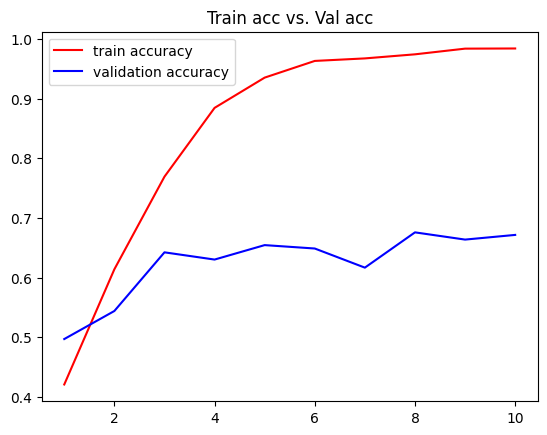

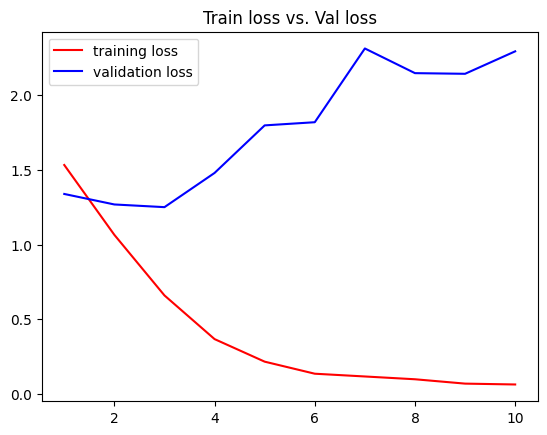

In [ ]:
visualizar_graficas(history_baseline)

### **3.2** MobileNetV3Large

In [10]:
mob_b3 = tf.keras.applications.MobileNetV3Large(
    input_shape = (256, 256, 3),
    include_top = False,
    weights = 'imagenet'
)

# Capa base congelada
mob_b3.trainable = False

# Clasificador después de mob nt v3
model_mob_b3 = tf.keras.Sequential([
    mob_b3,
    GlobalAveragePooling2D(),
    Dense(num_classes, activation='softmax')
])

/usr/local/lib/python3.12/dist-packages/keras/src/applications/mobilenet_v3.py:517: UserWarning: `input_shape` is undefined or non-square, or `rows` is not 224. Weights for input shape (224, 224) will be loaded as the default.
  return MobileNetV3(


12683000/12683000 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [11]:
model_mob_b3.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss="sparse_categorical_crossentropy",
    metrics=["accuracy"]
)

In [ ]:
history_mobb3 = model_mob_b3.fit(
    train_data,
    validation_data=val_data,
    epochs = epochs
)

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 61s 123ms/step - accuracy: 0.1857 - loss: 1.8020 - val_accuracy: 0.2450 - val_loss: 1.7468
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.2885 - loss: 1.7284 - val_accuracy: 0.2571 - val_loss: 1.7222
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.2997 - loss: 1.7011 - val_accuracy: 0.2870 - val_loss: 1.7031
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.3210 - loss: 1.6784 - val_accuracy: 0.3098 - val_loss: 1.6826
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.3222 - loss: 1.6669 - val_accuracy: 0.3098 - val_loss: 1.6721
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.3318 - loss: 1.6521 - val_accuracy: 0.3276 - val_loss: 1.6634
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 39ms/step - accuracy: 0.3374 - loss: 1.6430 - val_accuracy: 0.3212 - val_loss: 1.6486
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.3403 - loss: 1.6350 -

In [ ]:
model_mob_b3.save("trash_model_mobnetv3.keras")

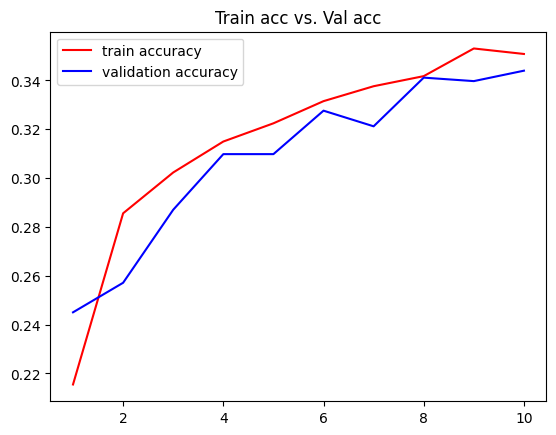

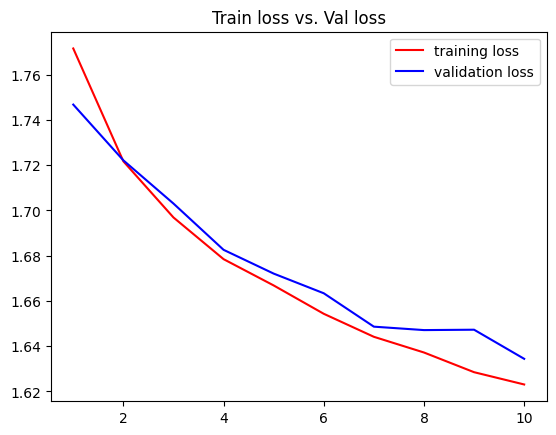

In [ ]:
visualizar_graficas(history_mobb3)

### **3.3.** EfficientNetB0

In [ ]:
effnet_b0 = tf.keras.applications.EfficientNetB0(
    input_shape = (256, 256, 3),
    include_top = False,
    weights = 'imagenet'
)
effnet_b0.trainable = False  # Congelamos las capas base

model_effnetb0 = tf.keras.Sequential([
    effnet_b0,
    GlobalAveragePooling2D(),
    Dense(num_classes, activation='softmax')
])

In [ ]:
history_effb0 = compile_and_fit(model_effnetb0, 10)

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 59s 115ms/step - accuracy: 0.1823 - loss: 1.8022 - val_accuracy: 0.1738 - val_loss: 1.8186
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.1806 - loss: 1.8051 - val_accuracy: 0.1638 - val_loss: 1.8046
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 21s 51ms/step - accuracy: 0.1859 - loss: 1.7986 - val_accuracy: 0.2108 - val_loss: 1.7978
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 50ms/step - accuracy: 0.1766 - loss: 1.8042 - val_accuracy: 0.1802 - val_loss: 1.8205
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.1756 - loss: 1.8012 - val_accuracy: 0.1816 - val_loss: 1.8088
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.1869 - loss: 1.7968 - val_accuracy: 0.2030 - val_loss: 1.7884
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 18s 51ms/step - accuracy: 0.1819 - loss: 1.7991 - val_accuracy: 0.1930 - val_loss: 1.7897
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 17s 50ms/step - accuracy: 0.1849 - loss: 1.7967 -

In [ ]:
model_effnetb0.save("trash_model_effnetb0.keras")

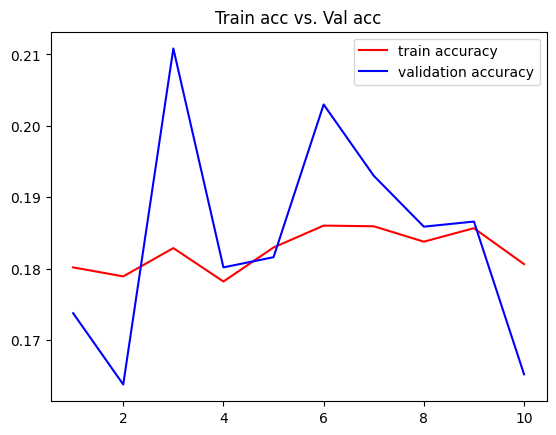

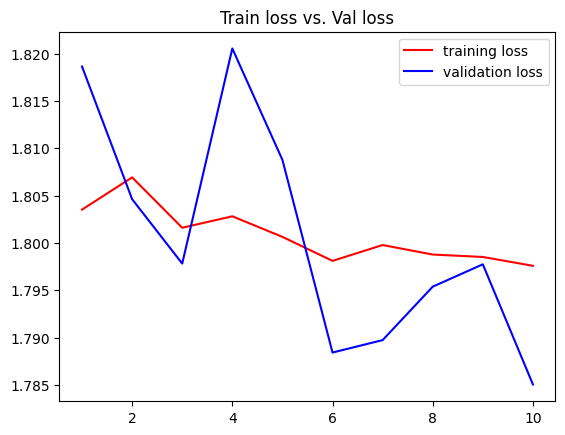

In [ ]:
visualizar_graficas(history_effb0)

## **4.** Mejora de modelo MobileNetV3Large

### **4.1** Intento 1

In [ ]:
model_imp1 = tf.keras.Sequential([
    mob_b3,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
history_imp1 = compile_and_fit(model_imp1, epochs)

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 45s 92ms/step - accuracy: 0.3496 - loss: 1.6158 - val_accuracy: 0.3647 - val_loss: 1.6244
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4384 - loss: 1.4521 - val_accuracy: 0.4608 - val_loss: 1.4132
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4590 - loss: 1.4104 - val_accuracy: 0.4879 - val_loss: 1.3554
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.4780 - loss: 1.3732 - val_accuracy: 0.5000 - val_loss: 1.3062
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.4888 - loss: 1.3454 - val_accuracy: 0.5071 - val_loss: 1.2994
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4901 - loss: 1.3224 - val_accuracy: 0.5235 - val_loss: 1.2559
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.5052 - loss: 1.2943 - val_accuracy: 0.5356 - val_loss: 1.2382
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.5126 - loss: 1.2698 - 

In [ ]:
model_imp1.save("mobnetv3_1.keras")

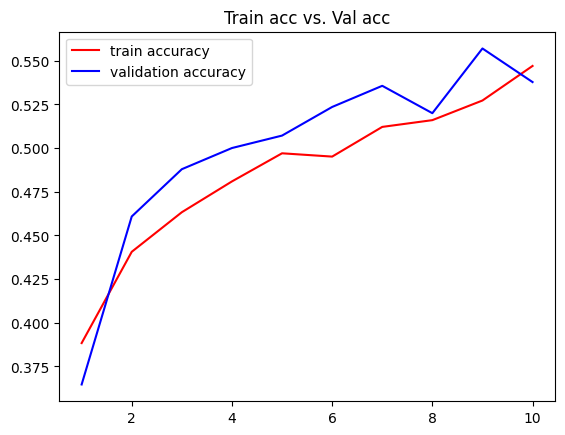

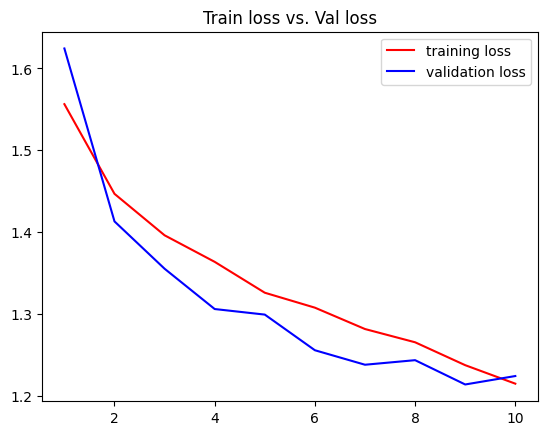

In [ ]:
visualizar_graficas(history_imp1)

### **4.2** Intento 2

In [ ]:
model_imp2 = tf.keras.Sequential([
    mob_b3,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])


In [ ]:
history_imp2 = compile_and_fit(model_imp2, epochs)

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 45s 93ms/step - accuracy: 0.3431 - loss: 1.6184 - val_accuracy: 0.3960 - val_loss: 1.6088
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4372 - loss: 1.4465 - val_accuracy: 0.4615 - val_loss: 1.4000
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4609 - loss: 1.3960 - val_accuracy: 0.4879 - val_loss: 1.3246
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.4767 - loss: 1.3498 - val_accuracy: 0.5093 - val_loss: 1.2785
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.4882 - loss: 1.3249 - val_accuracy: 0.5164 - val_loss: 1.2630
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 38ms/step - accuracy: 0.5096 - loss: 1.2909 - val_accuracy: 0.5242 - val_loss: 1.2411
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 21s 41ms/step - accuracy: 0.5049 - loss: 1.2812 - val_accuracy: 0.5385 - val_loss: 1.2253
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 16s 47ms/step - accuracy: 0.5165 - loss: 1.2450 - 

In [ ]:
model_imp2.save("mobnetv3_2.keras")

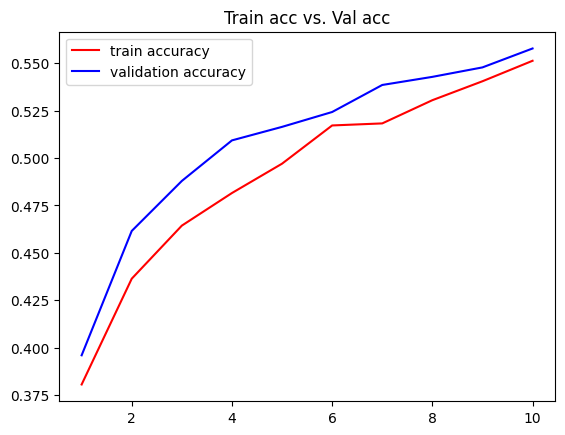

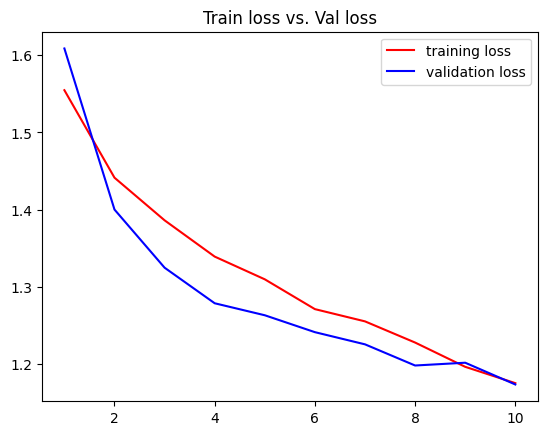

In [ ]:
visualizar_graficas(history_imp2)

### **4.3** Intento 3

In [ ]:
model_imp3 = tf.keras.Sequential([
    mob_b3,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dropout(0.4),
    Dense(128, activation='relu'),
    Dropout(0.4),
    Dense(64, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
history_imp3 = compile_and_fit(model_imp3, epochs)

Epoch 1/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 47s 94ms/step - accuracy: 0.2706 - loss: 1.7289 - val_accuracy: 0.3447 - val_loss: 1.6826
Epoch 2/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.3724 - loss: 1.5792 - val_accuracy: 0.4352 - val_loss: 1.4925
Epoch 3/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4021 - loss: 1.5261 - val_accuracy: 0.4487 - val_loss: 1.4229
Epoch 4/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4100 - loss: 1.5045 - val_accuracy: 0.4601 - val_loss: 1.4096
Epoch 5/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.4318 - loss: 1.4768 - val_accuracy: 0.4793 - val_loss: 1.3726
Epoch 6/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.4235 - loss: 1.4762 - val_accuracy: 0.4922 - val_loss: 1.3511
Epoch 7/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4390 - loss: 1.4476 - val_accuracy: 0.4879 - val_loss: 1.3480
Epoch 8/10
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4439 - loss: 1.4327 - 

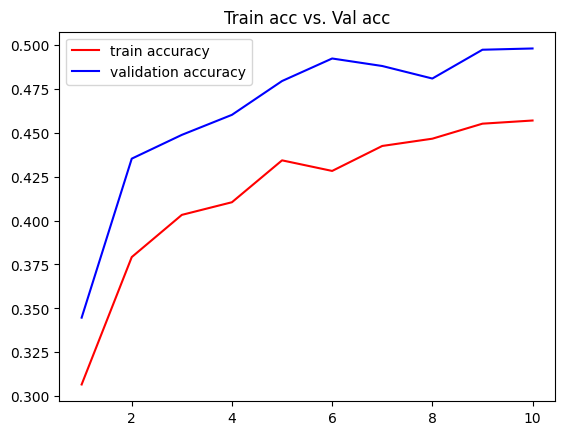

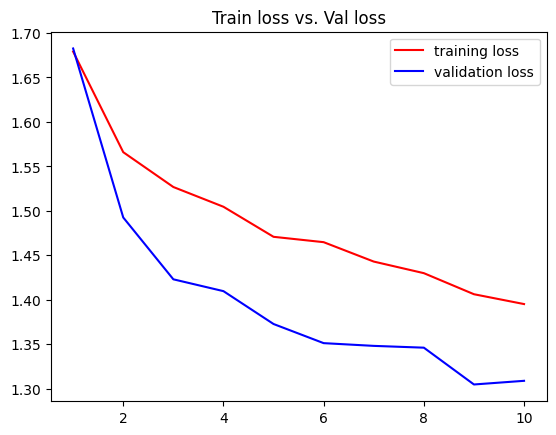

In [ ]:
visualizar_graficas(history_imp3)

### **4.4.** Intento 4

In [ ]:
model_imp4 = tf.keras.Sequential([
    mob_b3,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
history_imp4 = compile_and_fit(model_imp4, 20)

Epoch 1/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 44s 92ms/step - accuracy: 0.3416 - loss: 1.6224 - val_accuracy: 0.3625 - val_loss: 1.6365
Epoch 2/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.4352 - loss: 1.4560 - val_accuracy: 0.4608 - val_loss: 1.3953
Epoch 3/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4653 - loss: 1.3964 - val_accuracy: 0.4986 - val_loss: 1.3013
Epoch 4/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4874 - loss: 1.3500 - val_accuracy: 0.5036 - val_loss: 1.2932
Epoch 5/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.4971 - loss: 1.3096 - val_accuracy: 0.5121 - val_loss: 1.2477
Epoch 6/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.5116 - loss: 1.2781 - val_accuracy: 0.5342 - val_loss: 1.2058
Epoch 7/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5127 - loss: 1.2587 - val_accuracy: 0.5328 - val_loss: 1.2292
Epoch 8/20
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.5352 - loss: 1.2171 - 

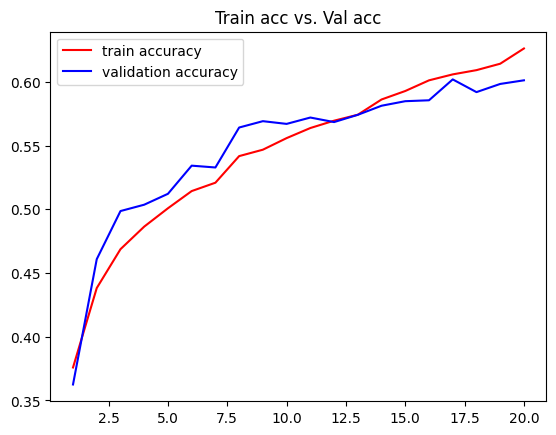

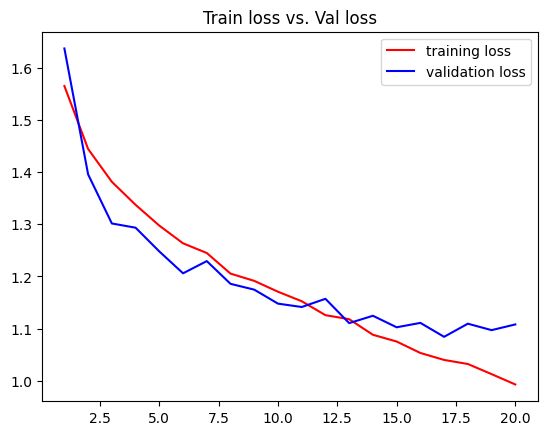

In [ ]:
visualizar_graficas(history_imp4)

### **4.5.** Intento 5

In [ ]:
model_imp5 = tf.keras.Sequential([
    mob_b3,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dense(128, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
history_imp5 = compile_and_fit(model_imp5, 150)

Epoch 1/150
348/348 ━━━━━━━━━━━━━━━━━━━━ 45s 90ms/step - accuracy: 0.3435 - loss: 1.6180 - val_accuracy: 0.3689 - val_loss: 1.6281
Epoch 2/150
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.4329 - loss: 1.4568 - val_accuracy: 0.4736 - val_loss: 1.3970
Epoch 3/150
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4662 - loss: 1.3886 - val_accuracy: 0.4907 - val_loss: 1.3082
Epoch 4/150
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4784 - loss: 1.3498 - val_accuracy: 0.5078 - val_loss: 1.2907
Epoch 5/150
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.5012 - loss: 1.3091 - val_accuracy: 0.5114 - val_loss: 1.2667
Epoch 6/150
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.5017 - loss: 1.2790 - val_accuracy: 0.5392 - val_loss: 1.2352
Epoch 7/150
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.5289 - loss: 1.2593 - val_accuracy: 0.5171 - val_loss: 1.2317
Epoch 8/150
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.5250 - loss: 1

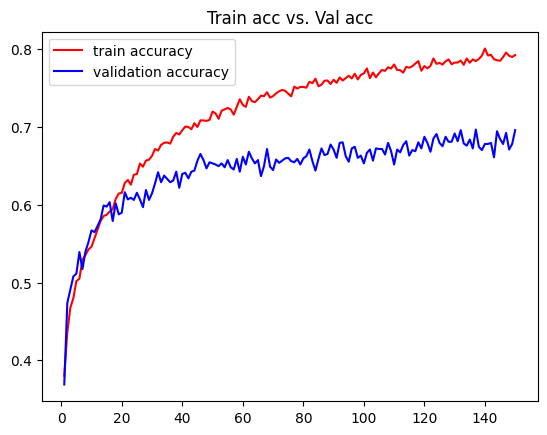

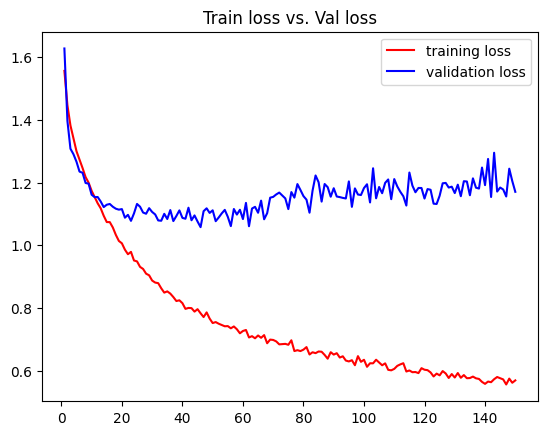

In [ ]:
visualizar_graficas(history_imp5)

In [ ]:
model_imp5.save('model_imp5.keras')

### **4.6** Intento 6

In [ ]:
model_imp6 = tf.keras.Sequential([
    mob_b3,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.4),
    Dense(256, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
history_imp6 = compile_and_fit(model_imp6, 100)

Epoch 1/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5404 - loss: 1.2114 - val_accuracy: 0.5670 - val_loss: 1.1912
Epoch 2/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.5482 - loss: 1.2028 - val_accuracy: 0.5655 - val_loss: 1.1704
Epoch 3/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 41ms/step - accuracy: 0.5492 - loss: 1.1844 - val_accuracy: 0.5442 - val_loss: 1.2031
Epoch 4/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.5538 - loss: 1.1726 - val_accuracy: 0.5598 - val_loss: 1.1756
Epoch 5/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 21s 39ms/step - accuracy: 0.5653 - loss: 1.1671 - val_accuracy: 0.5520 - val_loss: 1.2009
Epoch 6/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.5819 - loss: 1.1262 - val_accuracy: 0.5726 - val_loss: 1.1685
Epoch 7/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 23s 47ms/step - accuracy: 0.5748 - loss: 1.1352 - val_accuracy: 0.5698 - val_loss: 1.1896
Epoch 8/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.5856 - loss: 1

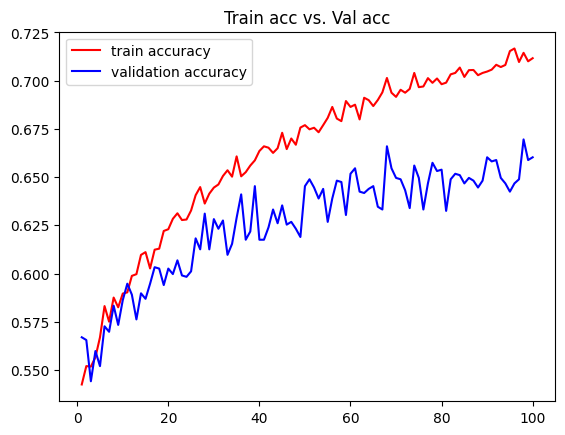

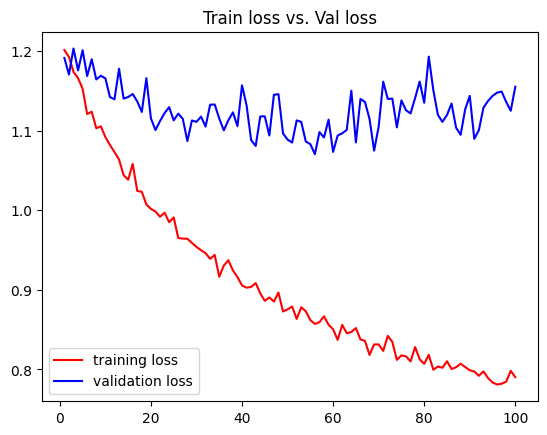

In [ ]:
visualizar_graficas(history_imp6)

In [ ]:
model_imp1.save("model_imp6.keras")

## **5.** Segunda iteración de mejora

### **5.1.** Modelo con más neuronas

In [ ]:
model_imp2_1 = tf.keras.Sequential([
    mob_b3,
    GlobalAveragePooling2D(),
    BatchNormalization(),
    Dropout(0.5),
    Dense(512, activation='relu'),
    Dense(num_classes, activation='softmax')
])

In [ ]:
history_imp2_1 = compile_and_fit(model_imp2_1, 100)

Epoch 1/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 44s 90ms/step - accuracy: 0.3487 - loss: 1.6274 - val_accuracy: 0.3526 - val_loss: 1.6422
Epoch 2/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 39ms/step - accuracy: 0.4204 - loss: 1.4849 - val_accuracy: 0.4573 - val_loss: 1.4466
Epoch 3/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 20s 39ms/step - accuracy: 0.4470 - loss: 1.4344 - val_accuracy: 0.4793 - val_loss: 1.3427
Epoch 4/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 13s 38ms/step - accuracy: 0.4556 - loss: 1.4036 - val_accuracy: 0.4872 - val_loss: 1.3293
Epoch 5/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.4774 - loss: 1.3576 - val_accuracy: 0.4964 - val_loss: 1.3076
Epoch 6/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.4787 - loss: 1.3537 - val_accuracy: 0.5100 - val_loss: 1.3021
Epoch 7/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.4852 - loss: 1.3297 - val_accuracy: 0.5349 - val_loss: 1.2579
Epoch 8/100
348/348 ━━━━━━━━━━━━━━━━━━━━ 14s 40ms/step - accuracy: 0.4969 - loss: 1

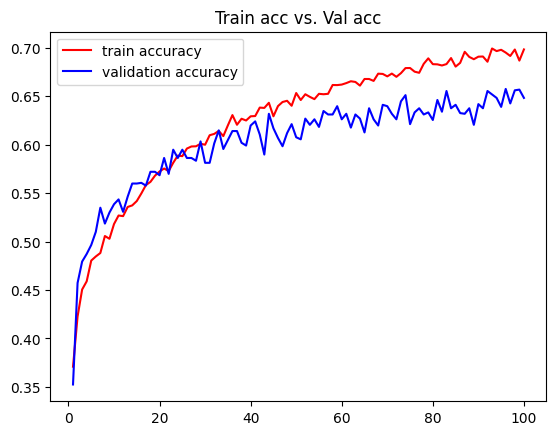

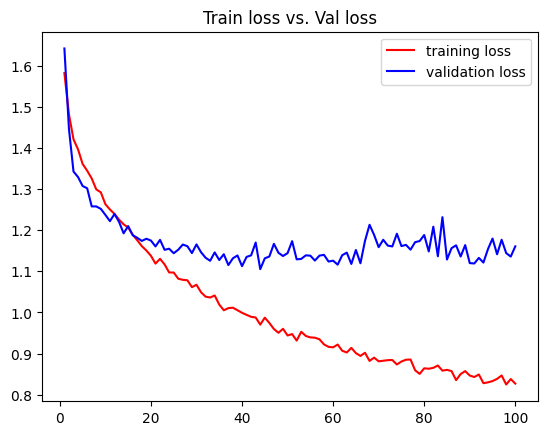

In [ ]:
visualizar_graficas(history_imp2_1)

### **5.2** Data Augmentation